In [ ]:
!pip install tensorflow
!pip install matplot 

In [ ]:
!pip install numpy
!pip install scikit-learn

In [100]:
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [4]:
IMAGE_SIZE= 224
BATCH_SIZE= 32
CHANNELS = 3
EPOCHS =20

In [5]:
dataset_path = 'Dataset'

In [60]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2041 files belonging to 2 classes.


In [99]:
class_name= dataset.class_names
print(class_name)
len(dataset)

['Fake', 'Real']


64

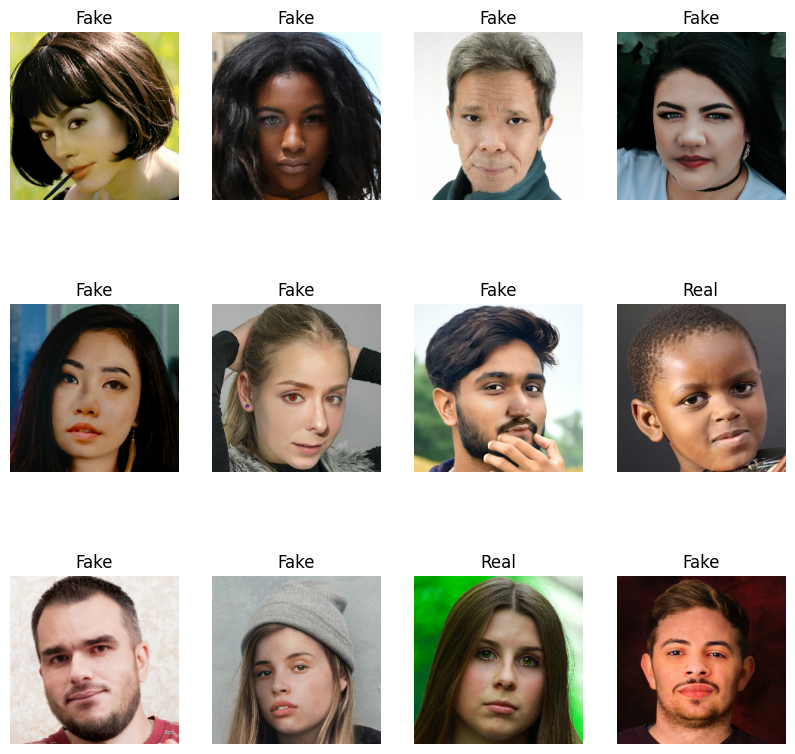

In [37]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_name[label_batch[i]])
    plt.axis("off")

In [49]:
def get_dataset_partition_tf(ds, train_split=0.7, val_split=0.2, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)  
    if shuffle:
        ds = ds.shuffle(shuffle_size, reshuffle_each_iteration=False)  # Shuffle the dataset

    # Defining the split sizes
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    # Spliting the dataset using take and skip
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

In [50]:
train_ds, val_ds, test_ds= get_dataset_partition_tf(dataset)

In [40]:
for image, label in train_ds.take(1):
    print(f"Image batch shape: {image.shape}, Label batch shape: {label.shape}")

Image batch shape: (32, 224, 224, 3), Label batch shape: (32,)


In [51]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

44
12
8


In [52]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [53]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)

])

In [16]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2)
])

In [62]:
for images, labels in train_ds.take(1):
    print("Label shape:", labels.shape)

Label shape: (32,)


In [63]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=INPUT_SHAPE),
    resize_and_rescale,
    #data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # L2 regularization
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_5  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_10 (Dense)            (None, 256)               327936    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                

In [64]:
model.compile(optimizer='adam',
            #optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

In [65]:
history = model.fit(
        train_ds,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=val_ds,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)]
    )

Epoch 1/20
44/44 [==============================] - 31s 630ms/step - loss: 1.1291 - accuracy: 0.5497 - val_loss: 1.0613 - val_accuracy: 0.5260
Epoch 2/20
44/44 [==============================] - 30s 682ms/step - loss: 0.9574 - accuracy: 0.6278 - val_loss: 0.9024 - val_accuracy: 0.6719
Epoch 3/20
44/44 [==============================] - 28s 631ms/step - loss: 0.8814 - accuracy: 0.6669 - val_loss: 0.8637 - val_accuracy: 0.6693
Epoch 4/20
44/44 [==============================] - 28s 643ms/step - loss: 0.8183 - accuracy: 0.6889 - val_loss: 0.8337 - val_accuracy: 0.6432
Epoch 5/20
44/44 [==============================] - 28s 632ms/step - loss: 0.7887 - accuracy: 0.6797 - val_loss: 0.7801 - val_accuracy: 0.6927
Epoch 6/20
44/44 [==============================] - 28s 633ms/step - loss: 0.7472 - accuracy: 0.7266 - val_loss: 0.7638 - val_accuracy: 0.6979
Epoch 7/20
44/44 [==============================] - 28s 639ms/step - loss: 0.7046 - accuracy: 0.7315 - val_loss: 0.7242 - val_accuracy: 0.7109

In [66]:
print(history)
print(history.params)
print(history.history.keys())

{'verbose': 1, 'epochs': 20, 'steps': 44}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [71]:
train_loss, train_acc = model.evaluate(train_ds)
val_loss, val_acc = model.evaluate(val_ds)
test_loss, test_acc = model.evaluate(test_ds)
print(f"Training Accuracy: {train_acc:.2f}")
print(f"Validation Accuracy: {val_acc:.2f}")
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Training Loss: {train_loss:.2f}")
print(f"Validation Loss: {val_loss:.2f}")
print(f"Test loss: {test_loss:.2f}")

8/8 [==============================] - 5s 643ms/step - loss: 0.5529 - accuracy: 0.8072
Training Accuracy: 0.92
Validation Accuracy: 0.79
Test Accuracy: 0.81
Training Loss: 0.39
Validation Loss: 0.61
Test loss: 0.55


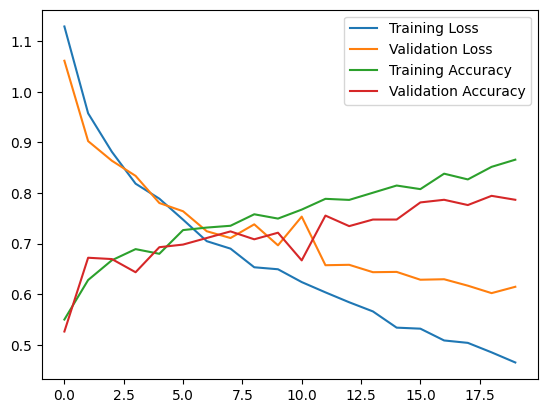

In [72]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [69]:
print(history.history['accuracy'])

acc= history.history['accuracy']
val_acc= history.history['val_accuracy']

loss= history.history['loss']
val_loss = history.history['val_loss']

[0.5497159361839294, 0.6278409361839294, 0.6669034361839294, 0.6889204382896423, 0.6796875, 0.7265625, 0.7315340638160706, 0.7350852489471436, 0.7578125, 0.7492897510528564, 0.7670454382896423, 0.7883522510528564, 0.7862215638160706, 0.8004261255264282, 0.8146306872367859, 0.8075284361839294, 0.8380681872367859, 0.8267045617103577, 0.8515625, 0.8657670617103577]


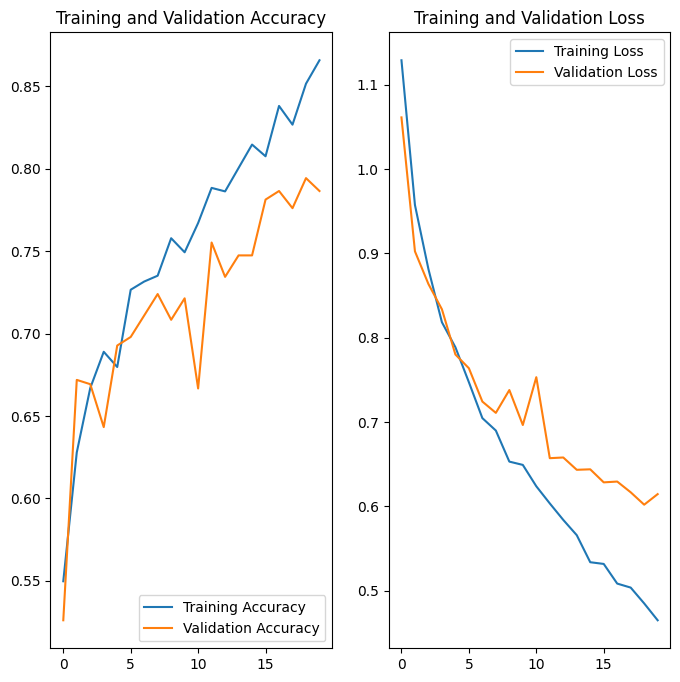

In [70]:
epochs_range = range(len(acc))  

plt.figure(figsize=(8, 8))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


1/1 [==============================] - 1s 519ms/step


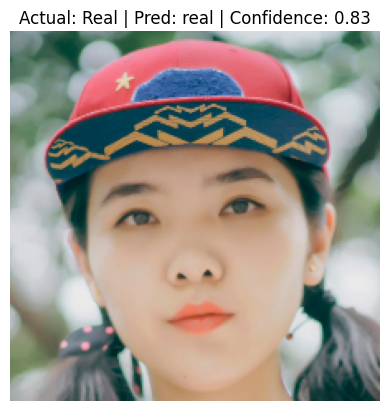

Actual label: Real
Predicted label: real
Confidence: 0.83


In [98]:
for images_batch, labels_batch in test_ds.take(1):

    # Getting the image and label
    second_image = images_batch[5].numpy().astype('uint8')
    second_label = labels_batch[5].numpy()

    # Getting predictions for the batch
    batch_prediction = model.predict(images_batch)

    # Threshold 
    threshold = 0.5

    # Converting predictions to 'real' or 'fake' based on the threshold
    batch_predictions_labels = ["real" if pred >= threshold else "fake" for pred in batch_prediction.flatten()]

    # Getting the predicted label for the second image
    second_image_prediction = batch_predictions_labels[5]
    second_image_confidence = batch_prediction[5][0]  # Probability of the second image

    # Ploting the second image
    plt.imshow(second_image)
    
    # Add the actual label, predicted label, and confidence on top of the image
    plt.title(f"Actual: {class_name[second_label]} | Pred: {second_image_prediction} | Confidence: {second_image_confidence:.2f}")
    plt.axis('off')  

    plt.show()

    print(f'Actual label: {class_name[second_label]}')
    print(f'Predicted label: {second_image_prediction}')
    if class_name[second_label]== 'Real':
        print(f'Confidence: {second_image_confidence:.2f}')
    else:
        print(f'Confidence: {1-second_image_confidence:.2f}')  
    

In [102]:
def predict_and_display(model, test_ds, class_name, image_index):
    # Get a batch of images and labels
    for images_batch, labels_batch in test_ds.take(1):

        # Getting the specific image and label
        image = images_batch[image_index].numpy().astype('uint8')
        label = labels_batch[image_index].numpy()

        # Geting predictions for the batch
        batch_prediction = model.predict(images_batch)

        #  Threshold
        threshold = 0.5

        # Converting predictions to 'real' or 'fake' based on the threshold
        batch_predictions_labels = ["real" if pred >= threshold else "fake" for pred in batch_prediction.flatten()]

        # Get the predicted label and confidence for the selected image
        image_prediction = batch_predictions_labels[image_index]
        image_confidence = batch_prediction[image_index][0]  # Probability of the image

        # Plot the image
        plt.imshow(image)
        
        # Add the actual label, predicted label, and confidence on top of the image
        plt.title(f"Actual: {class_name[label]} | Pred: {image_prediction}\nConfidence: {(image_confidence)*100:.2f}%")
        plt.axis('off') 

1/1 [==============================] - 0s 357ms/step


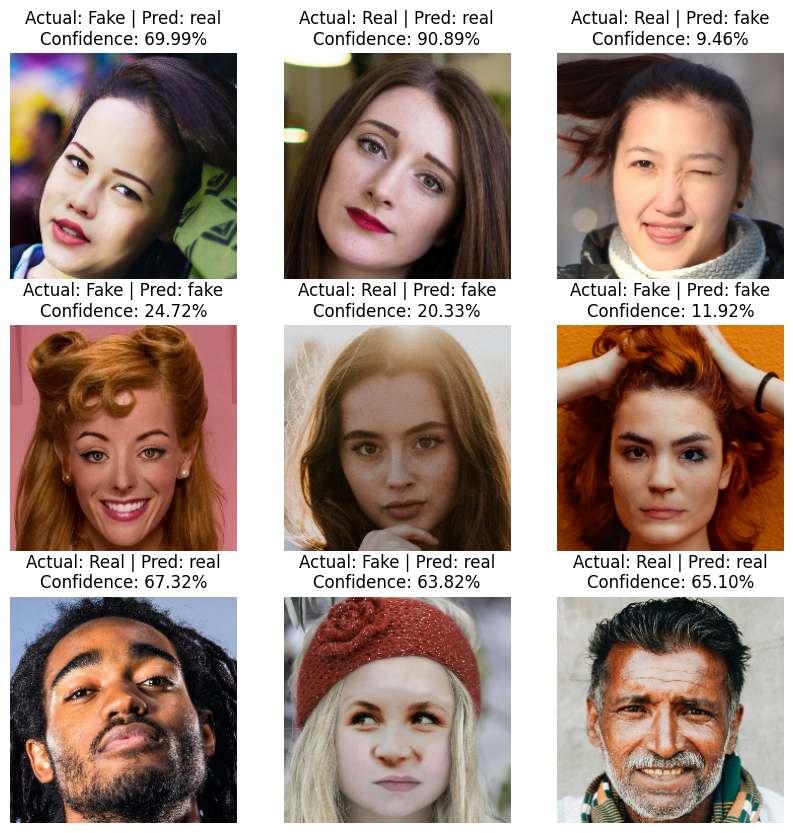

In [103]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        # Call the predict_and_display function for each image
        predict_and_display(model, test_ds, class_name, image_index=i)

plt.show()